# Desafio: Encontrando Padrões de Compra em E-commer de Games

Você é um analista de dados responsável por identificar padrões de comportamento dos jogadores em uma plataforma de venda de jogos.

Foi fornecido um dataset com 10.000 registros de compras, onde cada linha representa a aquisição de um jogo por um cliente. O objetivo é utilizar o algoritmo Apriori para descobrir regras de associação entre os jogos comprados.

## 🎯 Objetivo

Aplicar o algoritmo Apriori para:
- Identificar quais jogos são frequentemente comprados juntos.
- Avaliar as regras de associação mais relevantes com base em métricas como suporte, confiança e lift.
- Obter insights que possam ser usados em recomendações, bundles ou promoções futuras.

## 📊 Informações importantes sobre o dataset
O dataset possui 10 mil registros e 3 colunas:
- **Client ID**: Indentificador único para cada cliente na base de dados
- **Game ID**: Indentificador único para cada JOGO na base de dados
- **Game Name**: Nome comercial do jogo na base dados

## 💡 Sugestões de perguntas a serem feitas para EDA:
- Quantidade 'Game Name' únicos
- Quais os jogos mais vendidos
- Qual a porcentagem que um game aparece em relação a base de clientes


# Imports para EDA e ML

In [499]:
# EDA e Visualização de Dados
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from mlxtend.frequent_patterns import apriori, association_rules



# Carregar os dados

In [500]:
df = pd.read_csv('datasets/game_sales.csv')

In [501]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Client ID  10000 non-null  object
 1   Game ID    10000 non-null  object
 2   Game Name  10000 non-null  object
dtypes: object(3)
memory usage: 234.5+ KB


In [502]:
df.head(10)

,Client ID,Game ID,Game Name
0,CLIENT-0369,GAME-0013,Elden Ring
1,CLIENT-0287,GAME-0006,Call of Duty: Modern Warfare
2,CLIENT-0108,GAME-0030,PUBG: Battlegrounds
3,CLIENT-0291,GAME-0002,Minecraft
4,CLIENT-0277,GAME-0027,Battlefield 2042
5,CLIENT-0374,GAME-0009,Cyberpunk 2077
6,CLIENT-0034,GAME-0022,ARK: Survival Evolved
7,CLIENT-0316,GAME-0014,God of War Ragnarök
8,CLIENT-0375,GAME-0031,Destiny 2
9,CLIENT-0026,GAME-0016,Resident Evil 4


# EDA

In [503]:
# Quantidade 'Game Name' únicos
df['Game Name'].nunique()

33

In [504]:
# Quais 'Game Name' únicos?
df['Game Name'].unique()

array(['Elden Ring', 'Call of Duty: Modern Warfare',
       'PUBG: Battlegrounds', 'Minecraft', 'Battlefield 2042',
       'Cyberpunk 2077', 'ARK: Survival Evolved', 'God of War Ragnarök',
       'Destiny 2', 'Resident Evil 4', 'Fortnite', 'Hogwarts Legacy',
       'League of Legends', 'Monster Hunter: World', 'The Sims 4',
       'Red Dead Redemption 2', 'Overwatch 2', 'Among Us',
       'Rocket League', 'Dota 2', 'Fall Guys', 'Far Cry 6', 'Roblox',
       "Assassin's Creed Valhalla", 'Halo Infinite', 'Counter-Strike 2',
       'Apex Legends', 'FIFA 24', 'NBA 2K24', 'Genshin Impact',
       'The Witcher 3', 'Valorant', 'Grand Theft Auto V'], dtype=object)

In [505]:
# Quantidade 'Game ID' únicos?
df['Game ID'].nunique()

33

In [506]:
# Quantos clientes únicos?
df['Client ID'].nunique()

591

In [507]:
# Um Game aparece mais de uma vez para um mesmo Cliente ID?
len(df.groupby(['Client ID', 'Game ID'])) != len(df)

False

In [508]:
# Quais os jogos mais vendidos?
contagem_games = df['Game Name'].value_counts()
# Plot
fig_contagem_games = px.bar(contagem_games, color=contagem_games, orientation='h')
fig_contagem_games.update_layout(showlegend=False)
fig_contagem_games.show()


In [509]:
# Top 5 dos jogos mais vendidos?
contagem_games_top5 = df['Game Name'].value_counts().head(5)
# Plot
fig_contagem_games_top5 = px.bar(contagem_games_top5, color=contagem_games_top5, orientation='h')
fig_contagem_games_top5.update_layout(showlegend=False)
fig_contagem_games_top5.show()

In [510]:
# Qual a porcentagem que um game aparece em relação a base de clientes, ou seja, dos clientes qual a porcentagem que comprou o game?
porcentagem_games = (contagem_games / df['Client ID'].nunique()) * 100
# Plot
fig_porcentagem_games = px.bar(porcentagem_games, color=porcentagem_games, orientation='h')
fig_porcentagem_games.update_layout(showlegend=False)
fig_porcentagem_games.show()

In [511]:
# Top 5 porcentagem que um game aparece em relação a base de clientes, ou seja, dos clientes qual a porcentagem que comprou o game?
porcentagem_games_top5 = ((contagem_games / df['Client ID'].nunique()) * 100).head(5)
# Plot
fig_porcentagem_games_top5 = px.bar(porcentagem_games_top5, color=porcentagem_games_top5, orientation='h')
fig_porcentagem_games_top5.update_layout(showlegend=False)
fig_porcentagem_games_top5.show()

# Preparação da Base Com Pivot Table

In [512]:
# Criar pivo table para aplicar o algoritmo Apriori

df_pivot = df.pivot_table(
    index='Client ID',
    columns='Game Name',
    values='Game ID',
    aggfunc='count',
    fill_value=0
)

In [513]:
df_pivot.head(10)

Game Name,ARK: Survival Evolved,Among Us,Apex Legends,Assassin's Creed Valhalla,Battlefield 2042,Call of Duty: Modern Warfare,Counter-Strike 2,Cyberpunk 2077,Destiny 2,Dota 2,...,NBA 2K24,Overwatch 2,PUBG: Battlegrounds,Red Dead Redemption 2,Resident Evil 4,Roblox,Rocket League,The Sims 4,The Witcher 3,Valorant
Client ID,,,,,,,,,,,,,,,,,,,,,
CLIENT-0001,1,1,0,1,0,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
CLIENT-0002,0,1,1,1,1,1,0,0,0,0,...,0,1,0,0,1,0,1,0,0,1
CLIENT-0003,1,1,1,0,0,1,1,1,1,0,...,1,0,1,0,1,1,1,1,0,1
CLIENT-0004,1,0,1,0,1,1,1,0,0,1,...,1,0,0,1,1,1,1,0,1,0
CLIENT-0005,1,0,1,0,1,1,0,1,1,1,...,0,1,0,0,0,1,1,1,0,0
CLIENT-0006,1,0,0,0,0,1,1,1,1,0,...,1,1,1,0,1,1,0,0,0,0
CLIENT-0007,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
CLIENT-0008,1,0,1,1,0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,1
CLIENT-0009,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [514]:
# Converter os dados da Pivot table para Boolean (True/False)
df_pivot = df_pivot.map(lambda x: x > 0)

In [515]:
df_pivot.head(10)

Game Name,ARK: Survival Evolved,Among Us,Apex Legends,Assassin's Creed Valhalla,Battlefield 2042,Call of Duty: Modern Warfare,Counter-Strike 2,Cyberpunk 2077,Destiny 2,Dota 2,...,NBA 2K24,Overwatch 2,PUBG: Battlegrounds,Red Dead Redemption 2,Resident Evil 4,Roblox,Rocket League,The Sims 4,The Witcher 3,Valorant
Client ID,,,,,,,,,,,,,,,,,,,,,
CLIENT-0001,True,True,False,True,False,True,True,True,True,False,...,True,True,True,True,True,True,True,True,True,True
CLIENT-0002,False,True,True,True,True,True,False,False,False,False,...,False,True,False,False,True,False,True,False,False,True
CLIENT-0003,True,True,True,False,False,True,True,True,True,False,...,True,False,True,False,True,True,True,True,False,True
CLIENT-0004,True,False,True,False,True,True,True,False,False,True,...,True,False,False,True,True,True,True,False,True,False
CLIENT-0005,True,False,True,False,True,True,False,True,True,True,...,False,True,False,False,False,True,True,True,False,False
CLIENT-0006,True,False,False,False,False,True,True,True,True,False,...,True,True,True,False,True,True,False,False,False,False
CLIENT-0007,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
CLIENT-0008,True,False,True,True,False,True,True,True,True,True,...,True,True,True,True,True,True,True,True,False,True
CLIENT-0009,True,True,False,True,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,False


In [516]:
# Renomear o eixo das colunas para None
df_pivot = df_pivot.rename_axis(None, axis=1)
# Dropar/Remover a Coluna Game ID
df_pivot.reset_index(inplace=True)
df_pivot.drop(columns=['Client ID'], inplace=True)
df_pivot

,ARK: Survival Evolved,Among Us,Apex Legends,Assassin's Creed Valhalla,Battlefield 2042,Call of Duty: Modern Warfare,Counter-Strike 2,Cyberpunk 2077,Destiny 2,Dota 2,...,NBA 2K24,Overwatch 2,PUBG: Battlegrounds,Red Dead Redemption 2,Resident Evil 4,Roblox,Rocket League,The Sims 4,The Witcher 3,Valorant
0,True,True,False,True,False,True,True,True,True,False,...,True,True,True,True,True,True,True,True,True,True
1,False,True,True,True,True,True,False,False,False,False,...,False,True,False,False,True,False,True,False,False,True
2,True,True,True,False,False,True,True,True,True,False,...,True,False,True,False,True,True,True,True,False,True
3,True,False,True,False,True,True,True,False,False,True,...,True,False,False,True,True,True,True,False,True,False
4,True,False,True,False,True,True,False,True,True,True,...,False,True,False,False,False,True,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,False,True,True,False,False,True,False,False,False,False,...,True,False,True,True,True,False,True,False,True,True
587,True,True,True,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
588,False,True,True,True,False,True,True,True,True,True,...,True,True,True,False,True,True,False,False,False,True
589,True,True,False,False,True,True,True,False,False,False,...,False,False,False,False,True,True,False,True,False,False


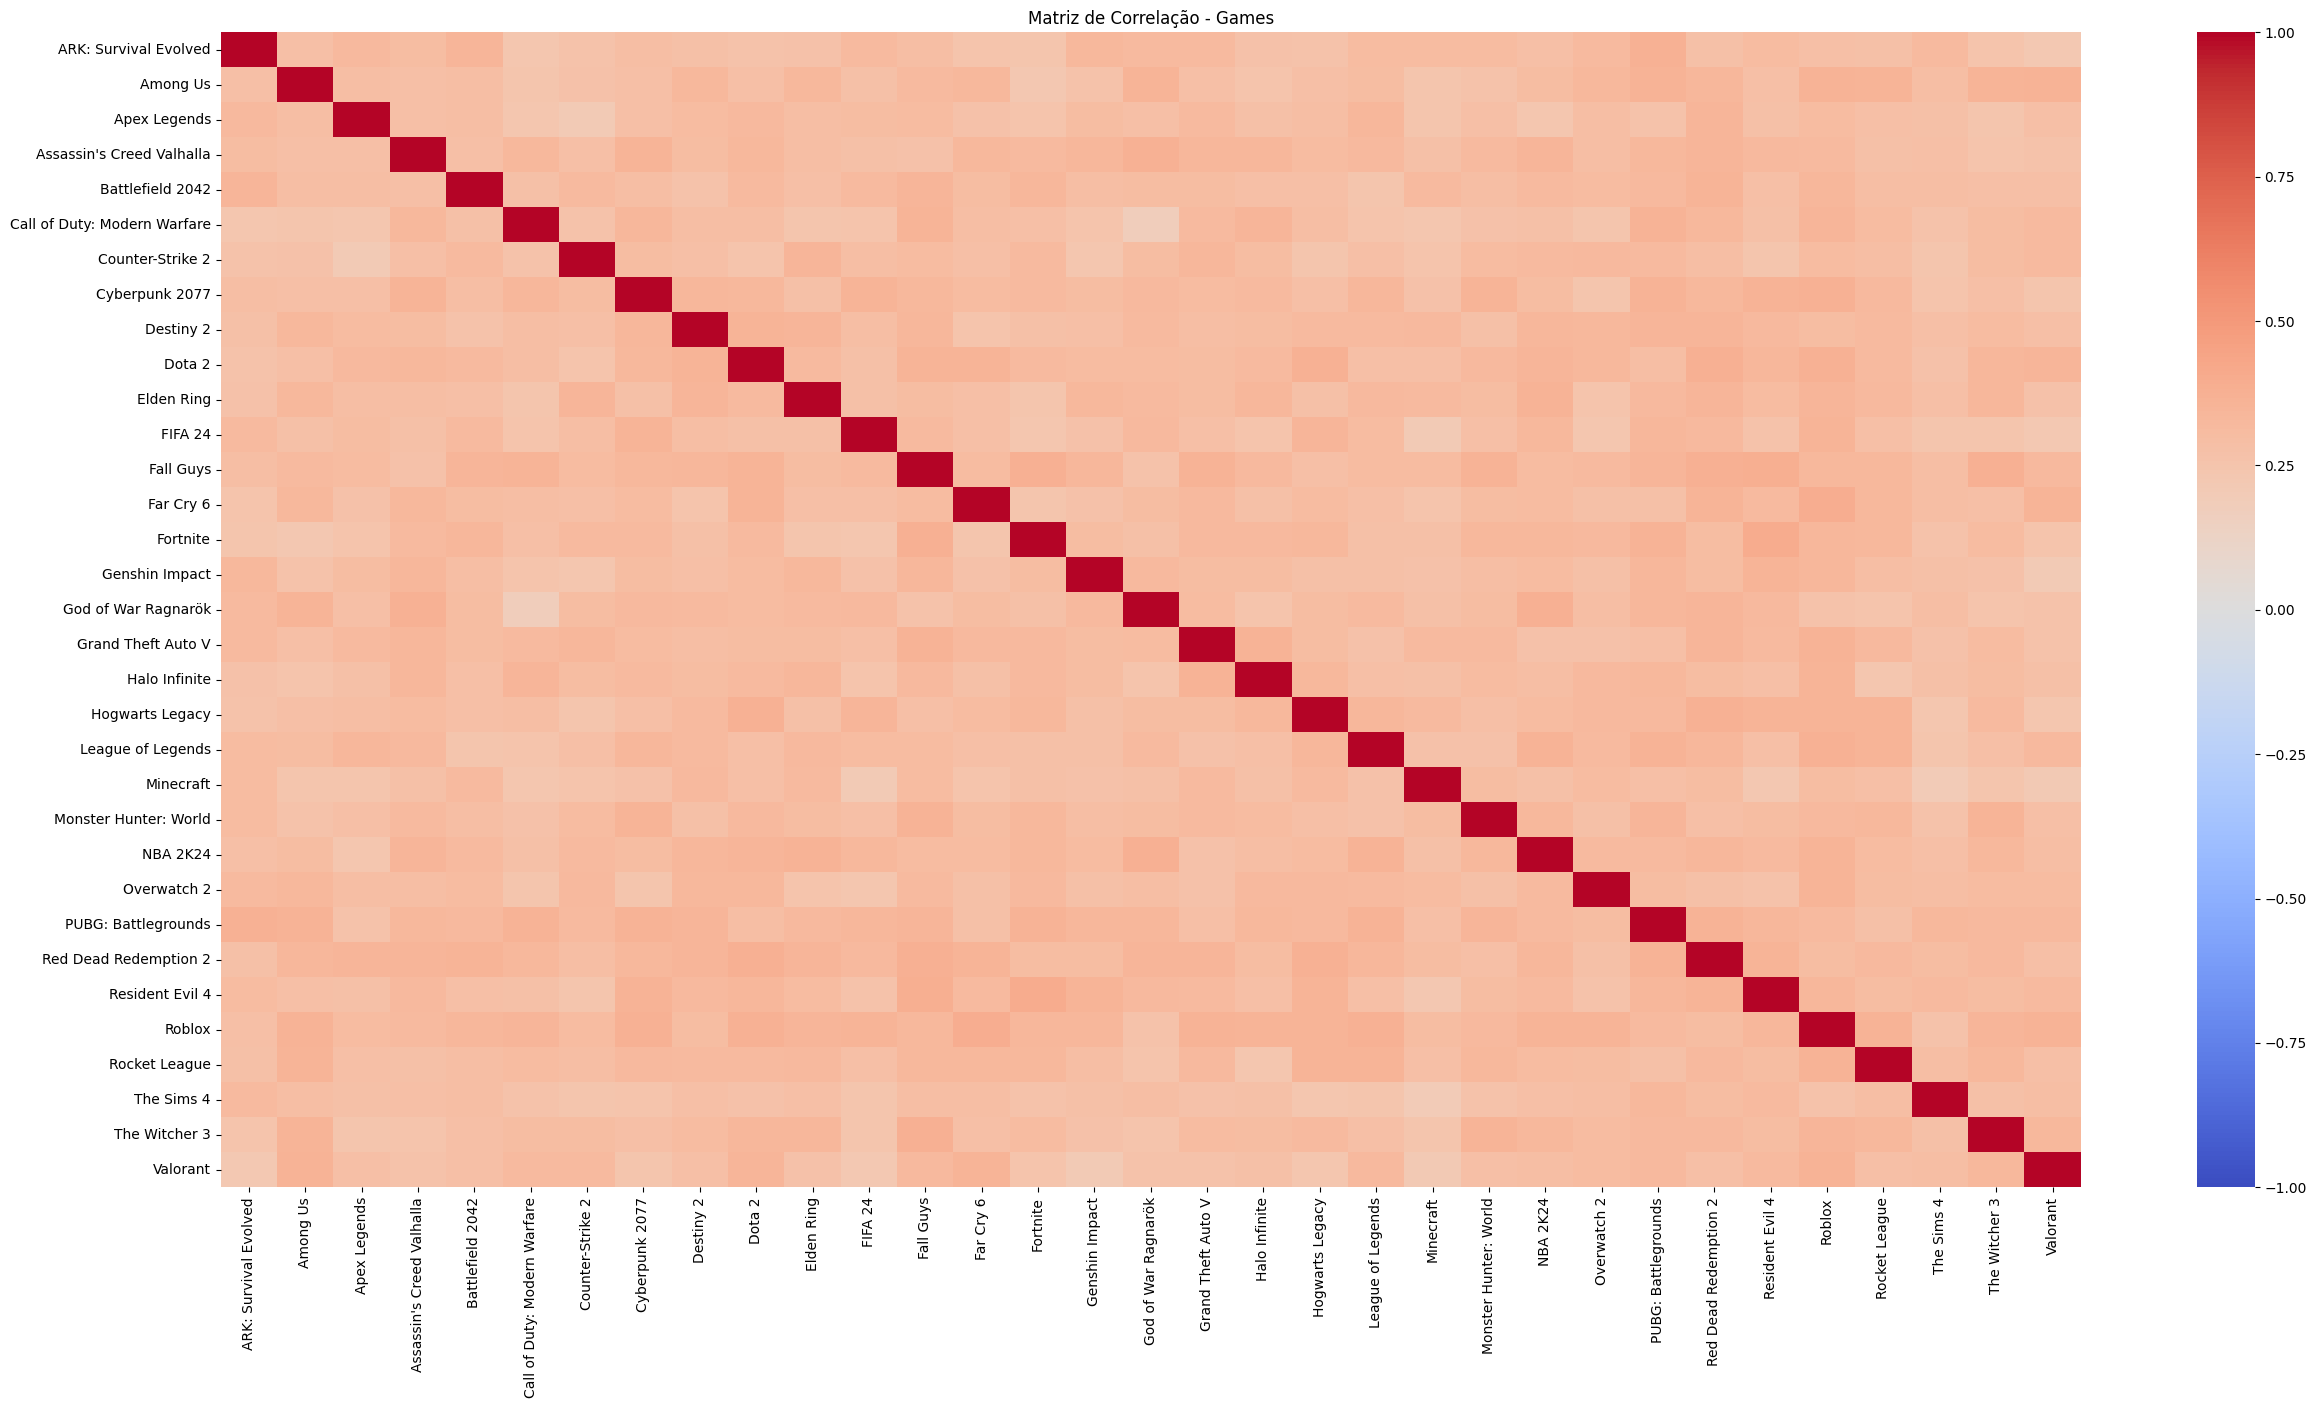

In [517]:
# Qual a correlação entre os games?

associacao_departamentos = df_pivot.corr()
plt.figure(figsize=(30, 15))
sns.heatmap(associacao_departamentos, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação - Games')
plt.show()

# Realizar Market Basket Analysis com Apriori

In [518]:
itemsets_frequentes = apriori(df_pivot, min_support=0.35, use_colnames=True, verbose=1)

Processing 3147 combinations | Sampling itemset size 3


In [519]:
# Quantos itemsets foram selecionados?
len(itemsets_frequentes)

173

In [520]:
# Criar uma coluna para armazenar o tamanho do itemset
itemsets_frequentes['tamanho'] = itemsets_frequentes['itemsets'].apply(lambda x: len(x))

In [521]:
# Quais são esses itemsets
itemsets_frequentes

,support,itemsets,tamanho
0,0.487310,(ARK: Survival Evolved),1
1,0.514382,(Among Us),1
2,0.519459,(Apex Legends),1
3,0.490694,(Assassin's Creed Valhalla),1
4,0.495770,(Battlefield 2042),1
...,...,...,...
168,0.370558,"(Overwatch 2, Roblox)",2
169,0.355330,"(Rocket League, Overwatch 2)",2
170,0.353638,"(Overwatch 2, Valorant)",2
171,0.363790,"(Rocket League, Roblox)",2


In [522]:
# Filtrar itemsets com 2 games
itemsets_frequentes[itemsets_frequentes['tamanho'] == 2]

,support,itemsets,tamanho
33,0.355330,"(Elden Ring, Among Us)",2
34,0.355330,"(Among Us, God of War Ragnarök)",2
35,0.358714,"(Overwatch 2, Among Us)",2
36,0.355330,"(PUBG: Battlegrounds, Among Us)",2
37,0.360406,"(Roblox, Among Us)",2
...,...,...,...
168,0.370558,"(Overwatch 2, Roblox)",2
169,0.355330,"(Rocket League, Overwatch 2)",2
170,0.353638,"(Overwatch 2, Valorant)",2
171,0.363790,"(Rocket League, Roblox)",2


In [523]:
# Criar Regras de Associação, com base nos itemsets frequentes
# usando confiança = 40%
regras_associacao_confidence = association_rules(itemsets_frequentes, metric="confidence", min_threshold=0.4)
regras_associacao_confidence

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Elden Ring),(Among Us),0.529611,0.514382,0.355330,0.670927,1.304334,0.082907,1.475712,0.496026
1,(Among Us),(Elden Ring),0.514382,0.529611,0.355330,0.690789,1.304334,0.082907,1.521259,0.480471
2,(Among Us),(God of War Ragnarök),0.514382,0.517766,0.355330,0.690789,1.334172,0.089000,1.559564,0.515779
3,(God of War Ragnarök),(Among Us),0.517766,0.514382,0.355330,0.686275,1.334172,0.089000,1.547906,0.519398
4,(Overwatch 2),(Among Us),0.538071,0.514382,0.358714,0.666667,1.296053,0.081940,1.456853,0.494505
...,...,...,...,...,...,...,...,...,...,...
275,(Valorant),(Overwatch 2),0.516074,0.538071,0.353638,0.685246,1.273523,0.075953,1.467587,0.443822
276,(Rocket League),(Roblox),0.522843,0.522843,0.363790,0.695793,1.330788,0.090426,1.568528,0.520930
277,(Roblox),(Rocket League),0.522843,0.522843,0.363790,0.695793,1.330788,0.090426,1.568528,0.520930
278,(Valorant),(Roblox),0.516074,0.522843,0.360406,0.698361,1.335700,0.090580,1.581880,0.519354


In [524]:
# Criar Regras de Associação, com base nos itemsets frequentes
# usando lift = 1.3
regras_associacao_lift = association_rules(itemsets_frequentes, metric="lift", min_threshold=1.35)
regras_associacao_lift

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Dota 2),(Roblox),0.500846,0.522843,0.355330,0.709459,1.356927,0.093466,1.642309,0.526973
1,(Roblox),(Dota 2),0.522843,0.500846,0.355330,0.679612,1.356927,0.093466,1.557965,0.551266
2,(Red Dead Redemption 2),(Fall Guys),0.494078,0.524535,0.353638,0.715753,1.364549,0.094477,1.672721,0.528060
3,(Fall Guys),(Red Dead Redemption 2),0.524535,0.494078,0.353638,0.674194,1.364549,0.094477,1.552830,0.561886
4,(Fall Guys),(Resident Evil 4),0.524535,0.504230,0.360406,0.687097,1.362665,0.095920,1.584419,0.559755
5,(Resident Evil 4),(Fall Guys),0.504230,0.524535,0.360406,0.714765,1.362665,0.095920,1.666925,0.536830
6,(Far Cry 6),(Roblox),0.482234,0.522843,0.350254,0.726316,1.389167,0.098122,1.743460,0.541063
7,(Roblox),(Far Cry 6),0.522843,0.482234,0.350254,0.669903,1.389167,0.098122,1.568528,0.587111
8,(Resident Evil 4),(Fortnite),0.504230,0.524535,0.365482,0.724832,1.381858,0.100996,1.727911,0.557388
9,(Fortnite),(Resident Evil 4),0.524535,0.504230,0.365482,0.696774,1.381858,0.100996,1.634986,0.581192


In [525]:
# Criar Regras de Associação, com base nos itemsets frequentes
# usando conviction = 7
regras_associacao_conviction = association_rules(itemsets_frequentes, metric="conviction", min_threshold=1.6)
regras_associacao_conviction

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Assassin's Creed Valhalla),(Call of Duty: Modern Warfare),0.490694,0.560068,0.357022,0.727586,1.299104,0.082200,1.614941,0.452063
1,(Assassin's Creed Valhalla),(Grand Theft Auto V),0.490694,0.541455,0.350254,0.713793,1.318287,0.084565,1.602145,0.474056
2,(Fall Guys),(Call of Duty: Modern Warfare),0.524535,0.560068,0.382403,0.729032,1.301686,0.088628,1.623560,0.487450
3,(PUBG: Battlegrounds),(Call of Duty: Modern Warfare),0.514382,0.560068,0.377327,0.733553,1.309757,0.089238,1.651104,0.487008
4,(Red Dead Redemption 2),(Call of Duty: Modern Warfare),0.494078,0.560068,0.358714,0.726027,1.296321,0.081997,1.605753,0.451821
5,(Dota 2),(Roblox),0.500846,0.522843,0.355330,0.709459,1.356927,0.093466,1.642309,0.526973
6,(Fall Guys),(Fortnite),0.524535,0.524535,0.370558,0.706452,1.346816,0.095422,1.619717,0.541592
7,(Fortnite),(Fall Guys),0.524535,0.524535,0.370558,0.706452,1.346816,0.095422,1.619717,0.541592
8,(Red Dead Redemption 2),(Fall Guys),0.494078,0.524535,0.353638,0.715753,1.364549,0.094477,1.672721,0.528060
9,(Resident Evil 4),(Fall Guys),0.504230,0.524535,0.360406,0.714765,1.362665,0.095920,1.666925,0.536830
